Before running:  
1. `conda install -c conda-forge folium`  
2. `pip install geojsoncontour`
3. Download and unzip data files from "UW EV Temperature Map/data/processed_0.2.zip" or ".../processed_1.0.zip"

In [1]:
#import os
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
from folium.plugins import TimestampedGeoJson
import matplotlib.pyplot as plt
#from scipy.interpolate import griddata
import geojsoncontour
#import scipy as sp
#import scipy.ndimage
import json

In [41]:
NUM_OF_MONTHS = 12
STEP = 7

In [42]:
# Setup colormap
# Copied and modified from ref. 2
colors = ['#8C00FF', '#007BFF', '#00C7FF', '#26FF00', '#FFFF00', '#FF7200', '#FF0000']
levels = [-70, -40, -20, 0, 10, 20, 40]
cm = branca.colormap.LinearColormap(colors=colors)
cm = cm.to_step(index=levels)
cm

In [43]:
def date_forward(month, day, step=1):
    """
    a function to forward date. e.g forward 4 days: 0428 ==> 0502
    """
    assert step > 0, "step must be positive"
    
    NUM_OF_DAYS = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
    day += step;
    while (month <= NUM_OF_MONTHS and day > NUM_OF_DAYS[month]):
        day -= NUM_OF_DAYS[month]
        month += 1
    
    return month, day

0101
0108
0115
0122
0129
0205
0212
0219
0226
0305
0312
0319
0326
0402
0409
0416
0423
0430
0507
0514
0521
0528
0604
0611
0618
0625
0702
0709
0716
0723
0730
0806
0813
0820
0827
0903
0910
0917
0924
1001
1008
1015
1022
1029
1105
1112
1119
1126
1203
1210
1217
1224
1231


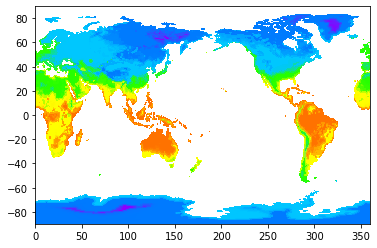

In [44]:
# read lon and lat coordinates. FILES ARE IN OUR GOOGLE DRIVE
# WILL CONSIDER USING SOME API TO ACCESS GOOGLE DRIVE FILES
# Copied and modified from ref. 1 and 2
lon = pd.read_csv('./processed_0.2/lon.csv', index_col=0)
lat = pd.read_csv('./processed_0.2/lat.csv', index_col=0)
x_mesh, y_mesh = np.meshgrid(lon, lat)

data = []
month, day = 1, 1
while(month <= NUM_OF_MONTHS):
    # read temperature data for a given date
    date = '{:02d}{:02d}'.format(month, day)
    print(date)
    filename = './processed_0.2/{}.csv'.format(date)
    tmp = pd.read_csv(filename, index_col=0)

    # convert to degree celcius
    z_mesh = tmp.subtract(273.15).to_numpy()

    # create the contour plot
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, alpha=0.5, colors=colors, linestyles='None', levels=levels)

    # Convert matplotlib contourf to geojson
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        ndigits=5,
        stroke_width=0.5,
        fill_opacity=0.5)

    d = json.loads(geojson)
    len_features=len(d['features'])
    # I had to provide a "full" time, e.g YYYY-MM-DD HH:mm:ss, otherwise folium won't be happy
    # only MM-DD is valid, and others are just random numbers.
    for j in range(0, len_features):
        d['features'][j]['properties']['time'] = '2019-' + date[:2] + '-' + date[2:] + ' 08:00:00'
    if not data:
        data.append(d)
    else:
        for i in range(len(d['features'])):
             data[0]['features'].append(d['features'][i])
    
    month, day = date_forward(month, day, STEP)

In [45]:
# some data formatting for `TimestampedGeoJson` plots
# completely copied from ref. 1
dict_act = data[0]
for i in range(len(dict_act['features'])):

    dict_act['features'][i]['properties']['color']=dict_act['features'][i]['properties'].pop('fill')
    dict_act['features'][i]['properties']['weight']=dict_act['features'][i]['properties'].pop('stroke-width')
    dict_act['features'][i]['properties']['fillOpacity']=dict_act['features'][i]['properties'].pop('fill-opacity')
    properties=dict_act['features'][i]['properties']
    gettime=properties.pop('time')
    new_properties = {'style': properties, 'times':[gettime]*len(dict_act['features'][i]['geometry']['coordinates'])}
    dict_act['features'][i]['properties'] = new_properties

In [ ]:
# copied and modified from ref. 1
# Set up the folium plot
geomap = folium.Map([0, 180], zoom_start=1.5, tiles="cartodbpositron")

# Plot the contour plot on folium
TimestampedGeoJson(
    dict_act,
    period='P14D',
    duration='P1D',
    transition_time=500,
    date_options='MM-DD',
    auto_play=False,
    loop_button=True,
    ).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Temperature(°C)'
geomap.add_child(cm)

In [47]:
# completely copied from ref. 2
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
geomap.save('./folium_contour_temperature_map.html')

references: 
1. https://github.com/samirak93/snow/blob/master/Complete_Notebook.ipynb
2. https://www.tjansson.dk/2018/10/contour-map-in-folium/ 

In [12]:
"""
# more data formatting for plotting multiple multipolygons in `TimestampedGeoJson` plots
fmtd_dict = {'features':[], 'type': 'FeatureCollection'}
for i in range(len(dict_act['features'])):
    for coordinates in dict_act['features'][i]['geometry']['coordinates']:
        feature = {'geometry':{'coordinates':[], 'type': 'Polygon'}, 'properties':{}, 'type': 'Feature'}
        feature['geometry']['coordinates'] = coordinates
        feature['properties'] = dict_act['features'][i]['properties']
        fmtd_dict['features'].append(feature)
"""